In [1]:
import collections
import functools
import itertools
import re
import string
import timeit

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.api import StringTokenizer
from nltk.tokenize import TweetTokenizer
import numpy as np
import pandas as pd
import sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from utils import *
from topic_utils import *

In [2]:
# suppress stop words mismatch warning
import warnings
warnings.simplefilter('ignore')

In [ ]:
#nltk.download('popular')

# Text processing

## Pipeline:
We are starting with a series of strings representing individual tweets. We can perform our analysis on
- individual tweets
- all tweets for a grouping of the dataframe (e.g. group by userid)
- all tweets in the corpus

In addition,
- hashtags and urls are already in a separate column, as a list of strings.

In general, we want to convert tweet text into tokens for analysis. We will make utility functions which anticipate tokenizing for these levels of analysis.

1. Individual tweets are strings; groups of tweets are lists of strings
1. Preprocessing:
    1. Remove uninformative symbols
    1. Remove 'RT'
    1. Replace urls, hashtags, and @-mentions with generic tokens
    1. Remove stopwords
    1. Lemmatize
1. Apply preprocessing to column of strings OR column of lists of strings
    - Treat column of strings as a single list of strings

In [3]:
users = UsersData('data/users')
tweets = TweetsData('data/tweets')

In [4]:
df = tweets.df.loc[:][:]
user_df = users.df.loc[:][:]

In [5]:
campaign = df[df['campaign'] == 'iran202012']
campaign_users = user_df[user_df['campaign'] == 'iran202012']

Aggregation for tweet text can be defined as joining tweet strings into a list of strings:

In [6]:
string_agg = lambda x: list(x)

user_tweets = (campaign
               .groupby('userid')[['tweet_text']]
               .agg(string_agg)
              )
user_tweets.head()

,tweet_text
userid,
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=,[America and the way its government treats its...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=,[@ManotoNews اگه ایران به یمن و مقاومت کمک نکن...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=,[People are not silent! This structure must ch...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=,[El pueblo indígena Kayapo cerró una important...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=,[@VoteMarsha Why Women Prefer to Vote for an r...


### Pipeline usage

We can test our pipeline for tokenizing the datasets by aggregating all tweets for each user, allowing us to characterize users by the overall contents of their activity.

In [11]:
def make_tokens(list_of_strings,
                stop_words=[*stopwords.words(),
                          '[URL]', '[AT]', '[HTAG]']):
    """Apply preprocessing and tokenization to a list of strings.
    Usage: 
            output = make_tokens(series_of_strings)

            output = df.apply(make_tokens)
            
    Return:
        A list of lists of tokens for each string.
    """    
    
    t1 = default_timer()

    processed_strings = [preprocess_string(string)
                         for string in list_of_strings]

    tokenized_strings = [tokenize_string(string,
                                         stop_words)
                          for string in processed_strings]
                         
    t2 = default_timer()
    print('elapsed', t2 - t1)
    
    return tokenized_strings

In [12]:
(user_tweets['tweet_text'].head(1)
               .map(make_tokens))

elapsed 0.04588548297761008


userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=    [[america, way, government, treats, people, mu...
Name: tweet_text, dtype: object

In [13]:
user_tokens = (user_tweets['tweet_text']
               .map(make_tokens)
               .map(long_list))

elapsed 0.02463101496687159
elapsed 0.0323667639750056
elapsed 0.1323388359742239
elapsed 0.48321458598366007
elapsed 4.355487441003788
elapsed 3.6464064350002445
elapsed 2.0189663630444556
elapsed 0.8000600829836912
elapsed 3.540419714001473
elapsed 0.35710215603467077
elapsed 0.09135449904715642
elapsed 85.57714807597222
elapsed 0.132177977997344
elapsed 0.19231875299010426
elapsed 0.08613954100292176
elapsed 0.07867181801702827
elapsed 0.030922167003154755
elapsed 0.01203947199974209
elapsed 0.0014992280048318207
elapsed 0.20353209000313655
elapsed 0.5098837640252896
elapsed 0.1937444659997709
elapsed 0.4642020110040903
elapsed 0.001483138999901712
elapsed 2.0360390100395307
elapsed 0.019161128031555563
elapsed 0.8922551489667967
elapsed 2.122468573972583
elapsed 0.03024798398837447
elapsed 0.0009408479672856629
elapsed 0.028042976977303624
elapsed 0.07950365904252976
elapsed 0.06830809998791665
elapsed 0.4438897949876264
elapsed 0.11724188103107736
elapsed 0.011574397969525307
elap

In [14]:
user_tokens

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     [america, way, government, treats, people, mus...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    [اگه, ایران, یمن, مقاومت, کمک, نکنه, خاک, تو, ...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    [people, silent, structure, must, change, hell...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     [pueblo, indígena, kayapo, cerró, impoante, ca...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    [women, prefer, vote, rapest, pedophile, reall...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     [good, look, tweet, agree, like, severe, hatre...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     [hapus, zionisme, hapus, penjajahan, israel, l...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      [karl, marx, leader, nothing, dems, asking, cr...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     [sick, tired, lied, amazing, go, vote, better,...
zk4khaX7A3XhX

## Word frequencies

In [15]:
def word_frequency(list_of_words):
    """
    Return:
        dict of {'word':'frequency'} sorted by frequency (high to low)
    """
    counts = collections.Counter(list_of_words)
    
    return dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

In [16]:
freq_dicts = (user_tokens
            .apply(word_frequency)
            )
freq_dicts

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     {'trump': 23, 'corona': 9, 'lies': 6, 'america...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    {'که': 48, 'از': 42, 'در': 40, 'با': 26, 'این'...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    {'trump': 116, 'people': 45, 'vote': 35, 'us':...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     {'eeuu': 299, 'policía': 174, 'venezuela': 162...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    {'silver': 9486, 'biden': 7030, 'price': 4722,...
                                                                      ...                        
y3KkURpZFjT+WeW9e6BcxBYRg311F8fz1eJ647ahQc=     {'trump': 146, 'president': 34, 'people': 34, ...
z3nCVBEHiIbcBhhxU2mOz5iWK4a7sUdGmRSPFM16G0=     {'yang': 1812, 'palestina': 1606, 'israel': 10...
zFlH+vHUhiZD2qvvCLYyiU76qOha9+iYxCn1NVmzw=      {'nothing': 5, 'twitter': 4, 'biden': 4, 'trum...
zTUtu8WZ3RwxnwgMsYXnTU107UXsn4MQU5wrg8IDOU=     {'sick': 1, 'tired': 1, 'lied': 1, 'amazing': ...
zk4khaX7A3XhX

In [17]:
from sklearn.feature_extraction import DictVectorizer
vectorizer = DictVectorizer(sparse=True)
tf = vectorizer.fit_transform(freq_dicts)

In [18]:
vectorizer.get_feature_names()

['#gt',
 '#iiyy',
 '#indonesiabutuhkerja',
 '@ampk',
 '@k',
 '@rewritingurmind',
 '@saracaerd',
 "a'alib",
 "a'lam",
 "a'mal",
 "a's",
 "a'uudzu",
 'a-a',
 'a-changing',
 'a-do',
 'a-ok',
 'a-ram',
 'a-s',
 'a-sarsak',
 'a-shamaliya',
 'a-shatti',
 'a-t-elle',
 'a-t-il',
 'a-thread',
 'a-u',
 'aa',
 'aaa',
 'aaah',
 'aaahh',
 'aaahhh',
 'aaalot',
 'aaamiiin',
 'aaamiiinnn',
 'aaamiin',
 'aaammiiin',
 'aaand',
 'aaaw',
 'aaawww',
 'aadi',
 'aae',
 'aaee',
 'aafia',
 'aah',
 'aahh',
 'aahhh',
 'aaj',
 'aaja',
 'aajaa',
 'aalan',
 'aalco',
 'aale',
 'aali',
 'aalihi',
 'aameen',
 'aamer',
 'aamevia',
 'aamii',
 'aamiiin',
 'aamiiinn',
 'aamiin',
 'aamiinn',
 'aamin',
 'aaminn',
 'aaminnn',
 'aammiiin',
 'aamphole',
 'aang',
 'aap',
 'aapan',
 'aapce',
 'aapl',
 'aapna',
 'aapoyar',
 'aaqibah',
 'aarhus',
 'aaron',
 'aashiaap',
 'aashrawi',
 'aashura',
 'aatish',
 'aawww',
 'aaya',
 'aazadi',
 'ab',
 'aba',
 'aba-aba',
 'ababil',
 'abaco',
 'abad',
 'abadan',
 'abadi',
 'abadie',
 'abadii'

In [19]:
corpus_freq_dict = word_frequency(long_list(user_tokens))
list(zip(corpus_freq_dict.keys(), corpus_freq_dict.values()))[:20]

[('via', 40982),
 ('completa', 25234),
 ('trump', 22582),
 ('irán', 18853),
 ('eeuu', 18729),
 ('yang', 18359),
 ('از', 15338),
 ('video', 14312),
 ('که', 14106),
 ('در', 13904),
 ('historia', 13126),
 ('israel', 12269),
 ('nota', 11551),
 ('presidente', 11395),
 ('people', 11139),
 ('palestina', 9959),
 ('gobierno', 9752),
 ('silver', 9506),
 ('biden', 9431),
 ('را', 8810)]

In [20]:
top_user = (campaign
           .groupby('userid')
           .size()
           .idxmax())
user_tweets.loc[top_user]

tweet_text    [¡Quedan 3 episodios para el final!\nSerie "El...
Name: 213589457, dtype: object

In [21]:
top_user_tokens = user_tokens.loc[top_user]
top_user_tokens[:20]

['quedan',
 'episodios',
 'final',
 'serie',
 'profeta',
 'josé',
 'días',
 'gmt',
 'repite',
 'nicaragua',
 'país',
 'seguro',
 'centroamérica',
 'competencia',
 'militares',
 'israelíes',
 'matar',
 'palestinos',
 'construcción',
 'empresa']

In [47]:
document_freq_dict = word_frequency(top_user_tokens)
len(document_freq_dict)

62325

## Word cloud

In [58]:
def visualize(data,
              from_frequencies=True,
              limit=100,
              color=(150,50,50)):
    """
    """
    cloud = WordCloud(background_color="white",
                  prefer_horizontal=0.9,
                  max_font_size=40,
                  relative_scaling=.5,
                  color_func=lambda *args,**kwargs:color)
    
    data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True)[:limit])
        
    if from_frequencies:
        cloud.generate_from_frequencies(data)
    else:
        cloud.generate(data)
    
    fig, ax = plt.subplots()
    ax.imshow(cloud)
    ax.axis('off')
    
    return fig

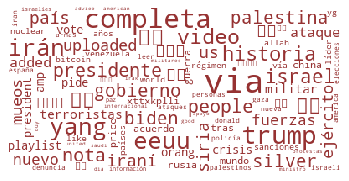

In [61]:
fig = visualize(corpus_freq_dict)

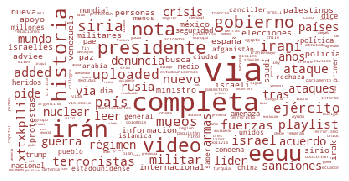

In [25]:
fig = visualize(document_freq_dict)

### Hashtag frequency + word cloud

In [26]:
hashtags = (campaign
               .loc[:]['hashtags']
               .fillna('')
               )
hashtag_list = [el.strip() for el in long_list(hashtags)
               if el != '']

In [27]:
hashtag_freq = word_frequency(hashtag_list)

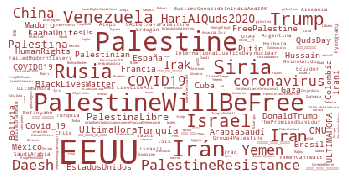

In [28]:
fig = visualize(hashtag_freq)

In [29]:
print('unique hashtags: {}'.format(len(hashtag_freq)))

unique hashtags: 37964


## Vectorizing

Using sklearn's Vectorizers to turn the corpus into a text-term matrix allows us to easily count tokens, and count n-grams as well as single-word tokens.

In [30]:
stop_words = [*stopwords.words(),
              '[url]', '[at]', '[htag]',
             ]
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, special_tokens=False)

In [31]:
vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

documents_list = (user_tweets['tweet_text']
                    .map(long_string)
                   )

In [32]:
documents_list[:5]

userid
+JkWMulEtCyTrcFDRO2XLv9EOdGHDl0GB9cdZUWgtA=     America and the way its government treats its ...
+fwTi4Wv1fs5sua3wZXqtBWBMMAy5IKNd5euWlP8Kuk=    @ManotoNews اگه ایران به یمن و مقاومت کمک نکنه...
0gTQ2cDCHFpYXKO+G367F1HBrPLupiuPjXuvmp9UL+w=    People are not silent! This structure must cha...
0hVjtURHlBEHZhn22rNDf98r+8VUXV3gi1bxvAhrZo=     El pueblo indígena Kayapo cerró una importante...
0zCl5U0pYu0gEmK3JtjO5fbnxEj6pO9GUgH52Q6yg0E=    @VoteMarsha Why Women Prefer to Vote for an ra...
Name: tweet_text, dtype: object

In [33]:
# tokenize + construct the frequency matrix from tokens
matrix = vectorizer.fit_transform(documents_list)

In [34]:
# get token names + frequencies
ngrams = vectorizer.get_feature_names()
ngram_frequencies = matrix.sum(axis=0).tolist()[0]
freq_dict = dict(zip(ngrams, ngram_frequencies))

In [35]:
matrix

<209x2578062 sparse matrix of type '<class 'numpy.int64'>'
	with 3448425 stored elements in Compressed Sparse Row format>

In [36]:
sorted(freq_dict.items(), key=lambda item: item[1], reverse=True)[:20]

[('via', 40982),
 ('completa', 25234),
 ('trump', 22582),
 ('irán', 18853),
 ('eeuu', 18729),
 ('yang', 18359),
 ('از', 15338),
 ('video', 14312),
 ('که', 14106),
 ('در', 13904),
 ('historia', 13126),
 ('israel', 12269),
 ('historia completa', 12192),
 ('nota', 11551),
 ('nota completa', 11445),
 ('presidente', 11395),
 ('people', 11139),
 ('palestina', 9959),
 ('gobierno', 9752),
 ('silver', 9506)]

# Topic extraction

Tutorial: https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#

In [38]:
# suggested scale
n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20

In [39]:
stop_words = [*stopwords.words(),
              '[url]', '[at]', '[htag]',]
tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
preprocess_partial = functools.partial(preprocess_string, special_tokens=False)

vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )

## Latent Dirichlet Allocation (LDA)

Latent Dirichlet Allocation is a generative probabilistic model which models a corpus as a random mixture of topics and uses the observed words to fit latent variables describing the mixture of topics and the distribution of words in the documents of the corpus.

A corpus consists of $D$ documents ($\sim$vector samples) of $N$ words ($\sim$entry samples) described by $K$ topics ($\sim$classes).

1. For each topic $k \in K$, draw $\beta_{k} \sim \text{Dirichlet}(\eta)$. This represents the probability of a word appearing in topic $k$.


1. For each document $d \in D$: draw the topic proportions $\theta_{d} \sim \text{Dirichlet}(\alpha).$

1. For each word $i$ in document $D$:
    1. Draw the topic assignment $z_{di} \sim \text{Multinomial}(\theta_{d})$
    2. Draw the observed word $w_{ij} \sim \text{Multinomial}(\beta_{z_{di}})$

For parameter estimation, the posterior distribution is:
$$
p(z,\theta,\beta\mid w,\alpha,\eta) = \frac{p(z,\theta,\beta\mid\alpha,\eta)}{p(w\mid\alpha,\eta)}
$$

Variational Bayesian method uses a simpler distribution to approximate the posterior distribution and optimizes parameters in an expectation-minimization procedure. Variational parameters are optimized to maximize the Evidence Lower Bound (ELBO) - maximizing ELBO is equivalent to minimizing the Kullback-Leibler (KL) divergence between the estimate $q$ and the true posterior $p$.

In [40]:
t1 = default_timer()

tf = vectorizer.fit_transform(documents_list)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

elapsed: 38.87528376100818


In [41]:
print(('n_samples: {}\nn_features: {}')
      .format(n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, 
                                max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t1 = default_timer()

lda.fit(tf)

t2 = default_timer()

print('elapsed: {}'.format(t2 - t1))

n_samples: 2000
n_features: 1000
elapsed: 47.15874065400567


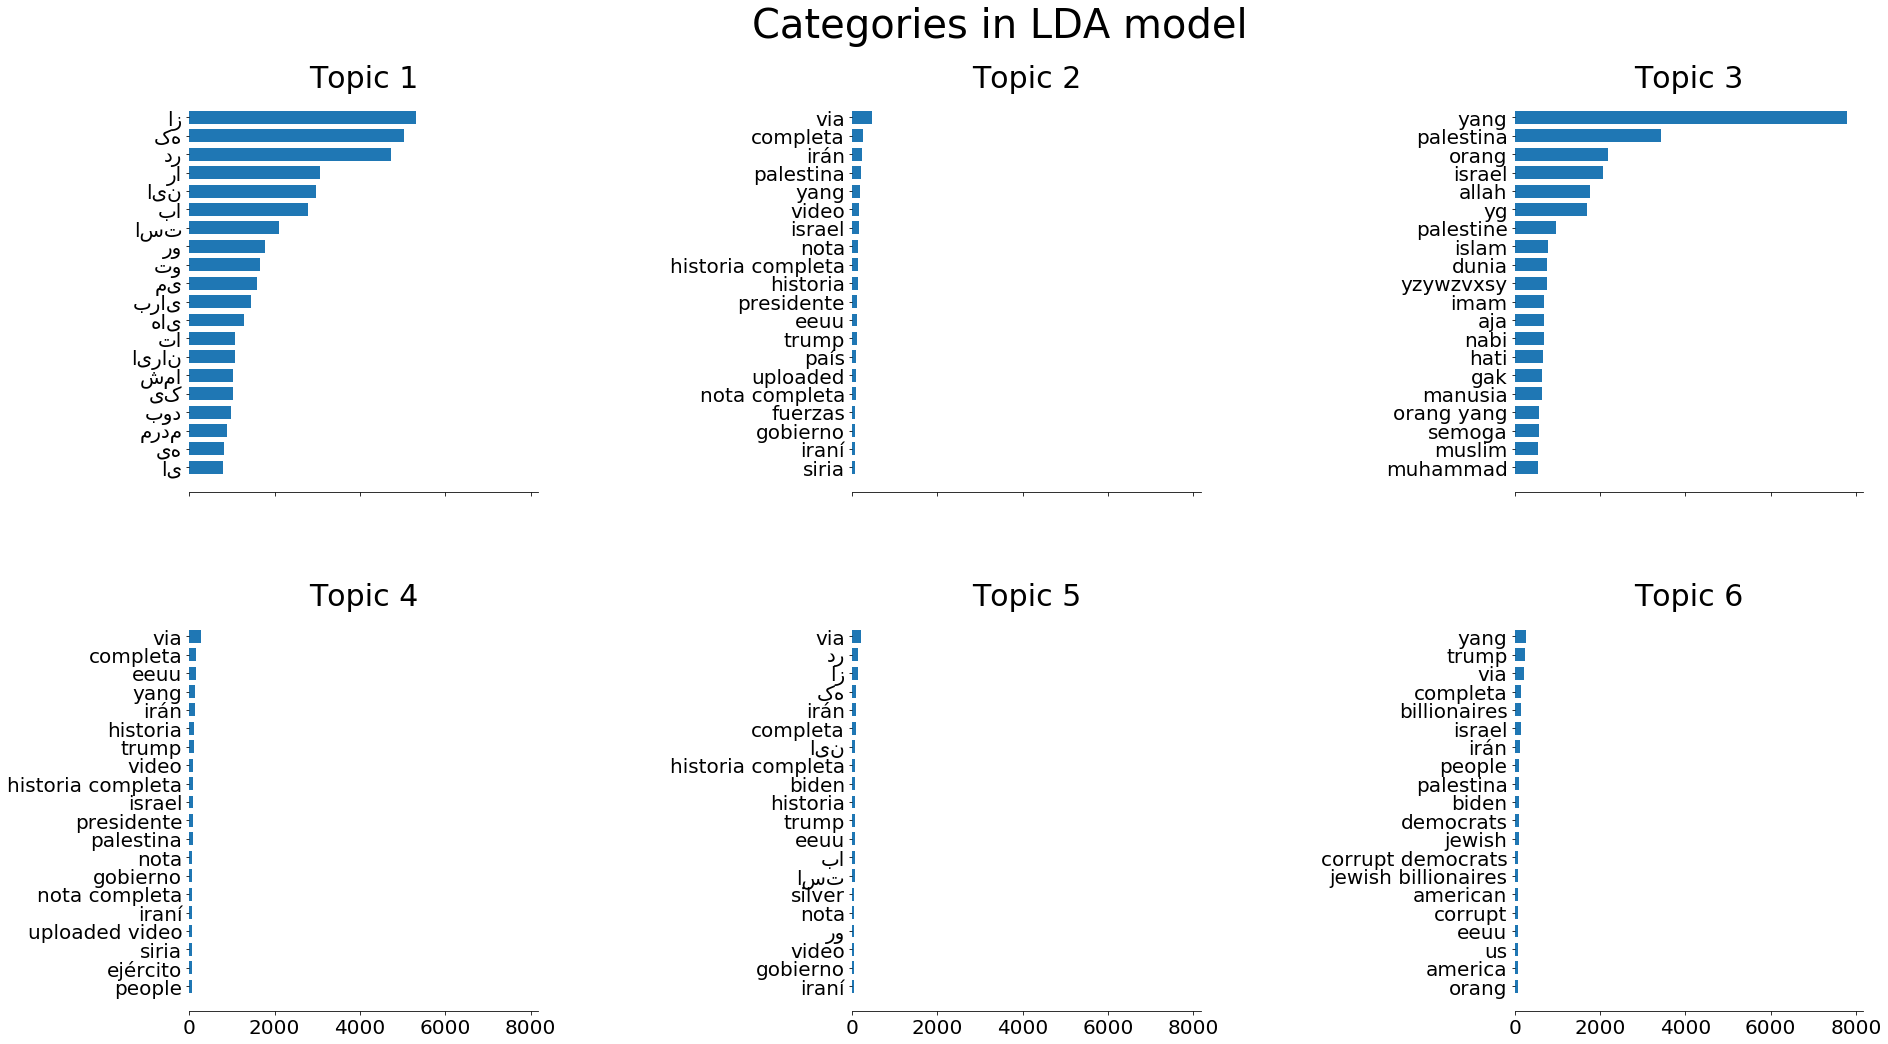

<Figure size 432x288 with 0 Axes>

In [42]:
tf_feature_names = vectorizer.get_feature_names()

plot_top_words(lda, 
               tf_feature_names, 
               n_top_words, 
               6,
               'Categories in LDA model')
plt.tight_layout()

Because the "document" level used in this case was per-user tweet token aggregates, we can perhaps consider these topics to be analogous to categories of users, based on their overall tweet set. Considering this campaign was so long, it is likely that the specific topics of tweets changed over time, so in further analysis, we might perform more filtering of the tweets in advance of clustering, for instance isolating tweets from a certain period of time.

In [43]:
"""Variational parameters for topic word distribution. 

Since the complete conditional for topic word distribution is a 
Dirichlet, components_[i, j] can be viewed as pseudocount that 
represents the number of times word j was assigned to topic i. 
It can also be viewed as distribution over the words for each 
topic after normalization: 
model.components_ / model.components_.sum(axis=1)[:, np.newaxis].
"""
lda.components_

array([[0.68801789, 0.60866241, 0.68842191, ..., 0.5889732 , 0.62284437,
        0.67410103],
       [0.60629299, 0.59361979, 0.64801018, ..., 0.60499627, 0.54382203,
        0.53741211],
       [1.45651894, 0.92475835, 1.18619684, ..., 0.7047135 , 0.72234893,
        0.62600304],
       ...,
       [0.57278512, 0.64634551, 0.58263569, ..., 0.60296245, 0.5853034 ,
        0.49451583],
       [0.54191633, 0.52692685, 0.61830417, ..., 0.61510437, 0.63087608,
        0.6324083 ],
       [0.51576177, 0.5560175 , 0.55186099, ..., 0.58113589, 0.5601597 ,
        0.63211518]])

### Utility function

In [46]:
def extract_topics(documents,
                   vectorizer=None,
                   n_samples=2000,
                   n_features=1000,
                   n_components=10,
                   n_top_words=20,
                   apply_preprocessing=True,
                   stop_words=None,
                   ):
    
    tokenize_partial = functools.partial(tokenize_string, stop_words=stop_words)
    preprocess_partial = functools.partial(preprocess_string, special_tokens=False)
    
    if stop_words == None:
        stop_words = [*stopwords.words(),
                      '[url]', '[at]', '[htag]',]
    if vectorizer == None:
        tokenize_partial = functools.partial(tokenize_string, 
                                             stop_words=stop_words)
        preprocess_partial = functools.partial(preprocess_string, 
                                               special_tokens=False)
        vectorizer = CountVectorizer(analyzer='word',
                             strip_accents='ascii',
                             stop_words=stop_words,
                             ngram_range=(1,2),
                             preprocessor=preprocess_partial,
                             tokenizer=tokenize_partial,
                            )
    if apply_preprocessing:
        documents = (documents
                          .map(long_string)
                          .map(preprocess_string)
                         )

    print('vectorizing...')
    tf = vectorizer.fit_transform(documents)
        
    
    print(('LDA:\nn_samples: {}\nn_features: {}\nn_components: {}')
          .format(n_samples, n_features, n_components))

    lda = LatentDirichletAllocation(n_components=n_components, 
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf)
    
    tf_feature_names = vectorizer.get_feature_names()

    plot_top_words(lda, 
                   tf_feature_names, 
                   n_top_words,
                   n_components,
                   'Categories in LDA model')
    plt.tight_layout()

vectorizing...
LDA:
n_samples: 2000
n_features: 1000
n_components: 6


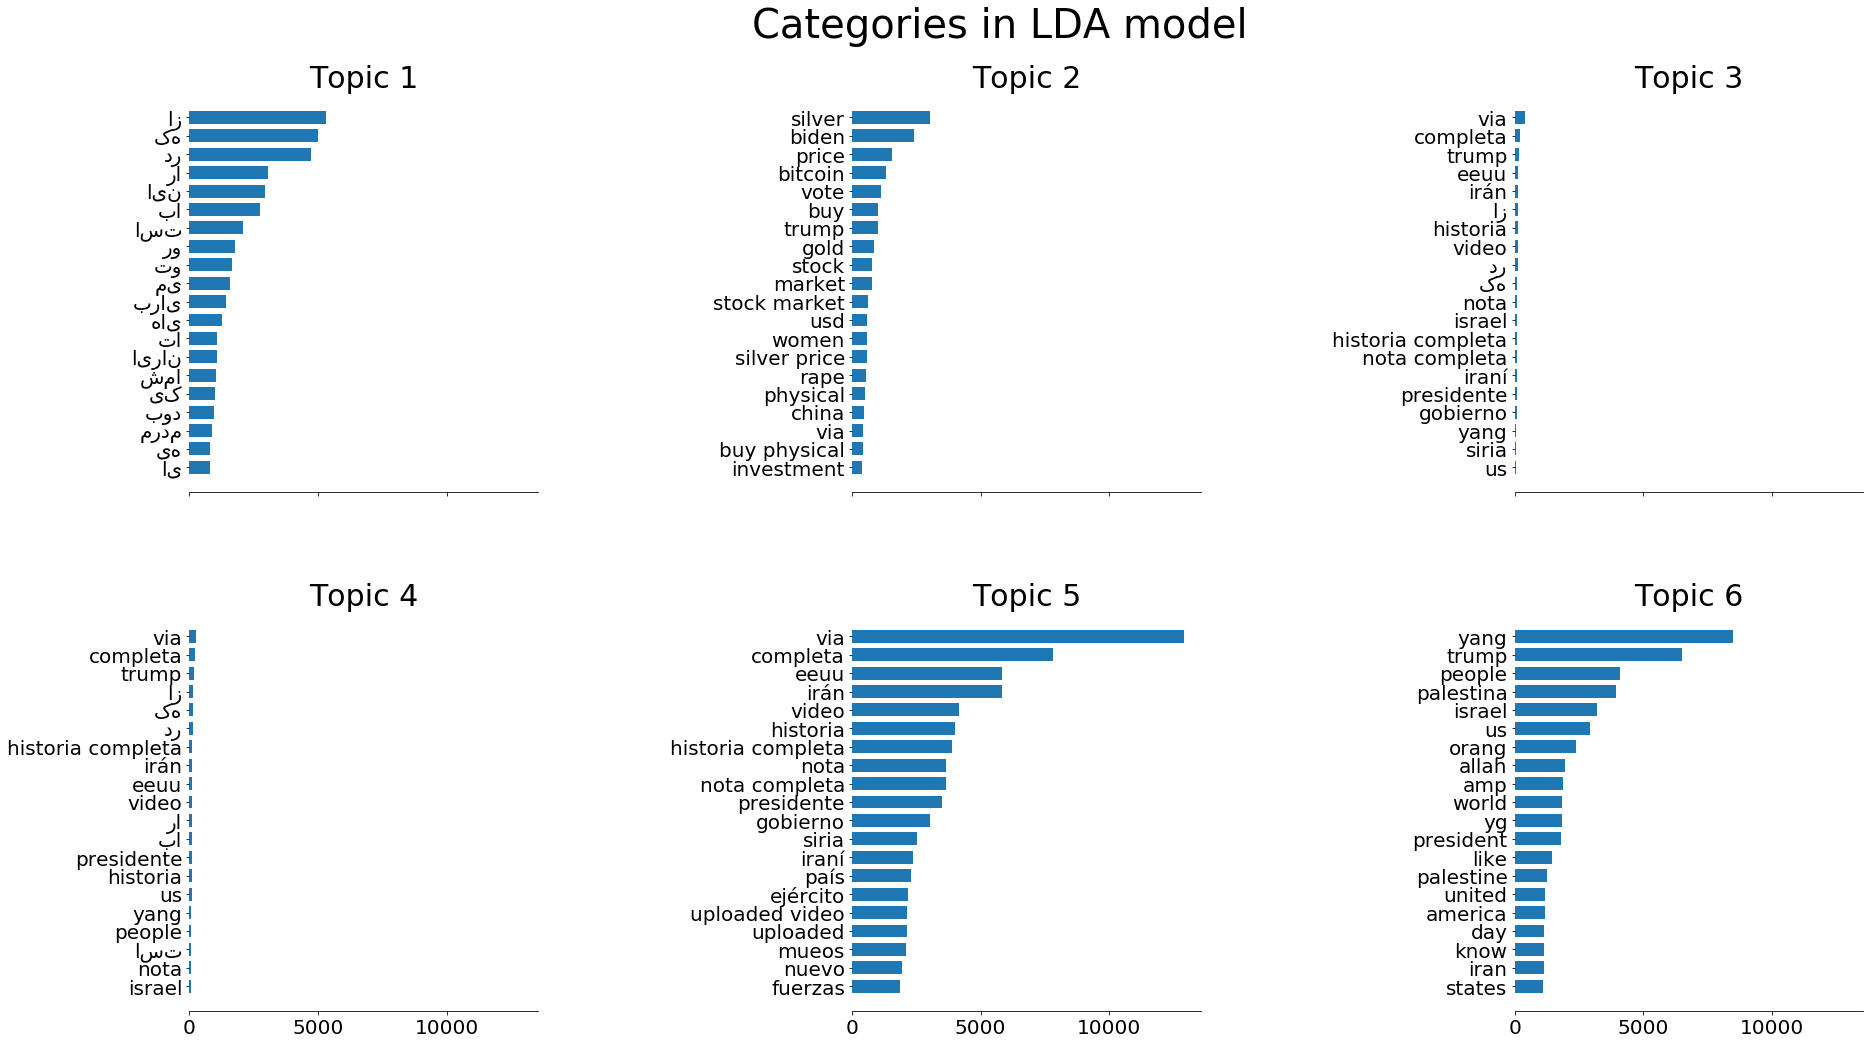

<Figure size 432x288 with 0 Axes>

In [45]:
extract_topics(user_tweets['tweet_text'],
               n_components=6)

### To do:
- mixtures of languages in topics? apply analysis to tweets separated by language? translate things?
- removing single characters re: arabic and emojis?